# Statistical study of alternative blocks/chains

Analysis by IsthmusCrypto for the [Monero Archival Project](https://github.com/mitchellpkt/monero_archival_project), a product of *#Noncesense-research-lab*

Contributors: [NeptuneResearch](https://github.com/neptuneresearch), [Nathan](https://github.com/neffmallon), [IsthmusCrypto](https://github.com/mitchellpkt)

This notebook investigates various phenomena related to mining of orphaned blocks and alt chains. This data was collected by a MAP archival node, running a customized daemon modified by NeptuneResearch.

You can jump to the **Results** section if you want to skip data import and cleaning/engineering.

### Background
See CuriousInventor's 5-minute [non-technical introduction](https://www.youtube.com/watch?v=t5JGQXCTe3c) to Bitcoin, for a review of why forks in the blockchain can occur naturally, and how they are resolved by the concensus process.

We will see several instances of these benign latency-induced forks, along with different alt-chain events from different mechanisms.

Monero aims for a 2-minute block time, by adjusting the 'difficulty' for the solutions. Since there is a heavy element of chance involved in mining, some intervals between blocks will be shorter/longer than 2-minutes.

### Conventions
The data in this analysis is already separated into blocks that became the main chain ("block0") and blocks were part of abandoned chains ("block1"). The block0 data is not recorded at heights with an alternate block. (*note to self, check for exceptions*)

The "random" field exists to differentiate each time a copy of a block is received (e.g. multiple times from multiple peers). Being able to distinguish between instances is important for latency studies, but not for the scope of this notebook, so it is dropped and de-duped.

# Preliminaries

## Where are files saved?

In [1]:
block0s_relative_path = (
    "data_for_analysis/block0s.txt.backup"
)  # without the earlier stuff tacked on
block1s_relative_path = "data_for_analysis/block1s.txt"


## Import libraries

In [2]:
from copy import copy
import time
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp


## Disable auto-scroll

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# Import and pre-process data

Two separate pandas DataFrames are used, `b0s` for main chain, and `b1s` for blocks that were abandoned

### Read in from CSV

In [4]:
# Read in the raw data from CSV files
b0s = pd.read_csv(block0s_relative_path)
b1s = pd.read_csv(block1s_relative_path)

### Sort the rows by height

In [5]:
b0s = b0s.sort_values("block_height")
b1s = b1s.sort_values("block_height")


### Glance at the data

In [6]:
display(b0s.describe())
display(b1s.describe())


,block_time,block_height,block_nonce,block_random
count,1.792500e+04,1.792500e+04,1.792500e+04,17925.000000
mean,1.529482e+09,1.599013e+06,8.307308e+08,16344.610711
std,6.193778e+05,5.177500e+03,1.271336e+09,9430.389673
min,1.528403e+09,1.590045e+06,0.000000e+00,2.000000
25%,1.528947e+09,1.594531e+06,6.073900e+04,8128.000000
50%,1.529481e+09,1.599014e+06,1.341939e+06,16393.000000
75%,1.530015e+09,1.603496e+06,1.541407e+09,24426.000000
max,1.530554e+09,1.607979e+06,4.291614e+09,32766.000000


,block_time,block_height,block_nonce,block_random
count,1.698000e+03,1.698000e+03,1.698000e+03,1698.000000
mean,1.525550e+09,1.566495e+06,6.986835e+08,16426.204947
std,2.188564e+06,1.777641e+04,1.021485e+09,9679.833141
min,1.522901e+09,1.545098e+06,3.300000e+01,26.000000
25%,1.523003e+09,1.546000e+06,4.966800e+05,7880.250000
50%,1.525759e+09,1.565742e+06,5.704308e+08,16544.000000
75%,1.527237e+09,1.580212e+06,5.704308e+08,24948.500000
max,1.530552e+09,1.607956e+06,4.203376e+09,32755.000000


In [7]:
b0s.head()


,block_time,block_height,block_nonce,block_random
0,1528402826,1590045,3221229389,24902
1,1528402878,1590046,3942645865,27044
2,1528402886,1590047,738273841,2570
3,1528402915,1590048,74924,4016
4,1528403287,1590049,1717987064,23717


### De-dupe

Because the MAP nodes record *every* instance that a block was received, most heights contain multiple copies from different peers. Each copy is identical, and stamped with a different `block_random`

For the purposes of this analysis/notebook, we only need one copy of each block.

Take a peek for current duplicaties:

In [8]:
b1s.head(20)


,block_time,block_height,block_nonce,block_random
0,1522901487,1545098,2684357998,11314
13,1522901487,1545098,2684357998,8118
12,1522901487,1545098,2684357998,7071
11,1522901487,1545098,2684357998,3800
9,1522901487,1545098,2684357998,27796
8,1522901487,1545098,2684357998,27186
7,1522901487,1545098,2684357998,24988
10,1522901487,1545098,2684357998,30751
5,1522901487,1545098,2684357998,17566
4,1522901487,1545098,2684357998,16865


First we remove the `block_random` *column*, so that multiple copies become indistinguishable.

In [9]:
b0s.drop(["block_random"], 1, inplace=True)
b1s.drop(["block_random"], 1, inplace=True)


Then drop the duplicate *rows*

In [10]:
b0s = b0s.drop_duplicates()
b1s = b1s.drop_duplicates()
b1s.head(20)


,block_time,block_height,block_nonce
0,1522901487,1545098,2684357998
439,1523003051,1546000,570430823
648,1523337099,1547963,2139397
654,1525032170,1562061,3579158795
655,1525032261,1562062,2970728396
660,1525219207,1563626,668103
666,1525470502,1565690,589661
667,1525470534,1565691,358009781
678,1525470959,1565692,2863312291
679,1525472810,1565693,1073825901


# Feature Engineering

Rather than looking at raw block timestamps, we'll want to study derived features like the time between blocks, alt chain lengths, etc.

## Generate difference columns

`delta_time` is the timestamp difference between two blocks. The `merlin_block` label is applied when a block's miner-reported timestamp precedes the one in the block prior. `delta_height` marks the difference in height between subsequent rows of the DataFrame, used as an imperfect proxy for identifying breaks between different alt chains.

In [11]:
b0s["delta_time"] = b0s["block_time"] - b0s["block_time"].shift()
b1s["delta_time"] = b1s["block_time"] - b1s["block_time"].shift()

b0s["merlin_block"] = 0  # unnecessary?
b1s["merlin_block"] = 0  # unnecessary?
b0s["merlin_block"] = b0s["delta_time"].transform(lambda x: x < 0).astype(int)
b1s["merlin_block"] = b1s["delta_time"].transform(lambda x: x < 0).astype(int)

b0s["delta_height"] = b0s["block_height"] - b0s["block_height"].shift()
b1s["delta_height"] = b1s["block_height"] - b1s["block_height"].shift()


### Replace delta_height != 1 to NaN

The first block in a alt chain (or following a gap in `b0s`) will have an anomalous `delta_time` and `delta_height`. We convert these to NaNs so that we can hang on to orphaned blocks and still have the start of alt chains included in our data set.

In [12]:
def mapper(x):
    if x == 1:
        return x
    else:
        return np.nan


b0s.delta_height = b0s.delta_height.map(mapper, na_action="ignore")
b0s.loc[b0s.delta_height.isnull(), ("delta_time")] = np.nan
b1s.delta_height = b1s.delta_height.map(mapper, na_action="ignore")
b1s.loc[b1s.delta_height.isnull(), ("delta_time")] = np.nan
b1s.head(20)


,block_time,block_height,block_nonce,delta_time,merlin_block,delta_height
0,1522901487,1545098,2684357998,NaN,0,NaN
439,1523003051,1546000,570430823,NaN,0,NaN
648,1523337099,1547963,2139397,NaN,0,NaN
654,1525032170,1562061,3579158795,NaN,0,NaN
655,1525032261,1562062,2970728396,91.0,0,1.0
660,1525219207,1563626,668103,NaN,0,NaN
666,1525470502,1565690,589661,NaN,0,NaN
667,1525470534,1565691,358009781,32.0,0,1.0
678,1525470959,1565692,2863312291,425.0,0,1.0
679,1525472810,1565693,1073825901,1851.0,0,1.0


### What are we left with?

In [13]:
print("Retained " + str(len(b0s)) + " main-chain blocks")
print("Retained " + str(len(b1s)) + " alt-chain blocks")


Retained 17925 main-chain blocks
Retained 241 alt-chain blocks


## Label alt chains

### Initialize new labels and features:

-  `alt_chain_ID` assigns an arbitrary integer to identify each alt chain. NOTE: there is a (bad) implicit assumption here alternate blocks at two subsequent heights belong to the same chain. Will be fixed in versions with linked blocks.
-  `alt_chain_length` records the length of the alt chain (up to each point, not retroactively adjusted)
-  `alt_chain_time` records how long a given chain has been growing (based on spoofable miner-reported timestamp)
-  `terminal_block` labels the 'end' block in each alt chain. Subject to artifacts from the limitation noted for alt_chain_ID.

In [14]:
b1s["alt_chain_ID"] = 0
b1s["alt_chain_length"] = (
    b1s["block_height"] - b1s["block_height"].shift()
)  # how long did this alt-chain get?
b1s["alt_chain_time"] = 0
b1s["terminal_block"] = 0  # is this the last block in the alt-chain?

b1s = b1s.reset_index()
b1s.drop(["index"], 1, inplace=True)
b1s.loc[0, ("alt_chain_length")] = 1  # since we don't know what preceded

b1s.loc[b1s.delta_time.isnull(), ("alt_chain_length")] = 1  # first block in chain
b1s.head(20)


,block_time,block_height,block_nonce,delta_time,merlin_block,delta_height,alt_chain_ID,alt_chain_length,alt_chain_time,terminal_block
0,1522901487,1545098,2684357998,NaN,0,NaN,0,1.0,0,0
1,1523003051,1546000,570430823,NaN,0,NaN,0,1.0,0,0
2,1523337099,1547963,2139397,NaN,0,NaN,0,1.0,0,0
3,1525032170,1562061,3579158795,NaN,0,NaN,0,1.0,0,0
4,1525032261,1562062,2970728396,91.0,0,1.0,0,1.0,0,0
5,1525219207,1563626,668103,NaN,0,NaN,0,1.0,0,0
6,1525470502,1565690,589661,NaN,0,NaN,0,1.0,0,0
7,1525470534,1565691,358009781,32.0,0,1.0,0,1.0,0,0
8,1525470959,1565692,2863312291,425.0,0,1.0,0,1.0,0,0
9,1525472810,1565693,1073825901,1851.0,0,1.0,0,1.0,0,0


### Add new info

Calculate accumulated alt chain length/time, and label terminal blocks.

Note that initialization of field `alt_chain_length` produces some value > 1 for the first block, and = 1 for subsequent blocks. Below, this is converted into actual alt chain lengths.

Convention: starting alt chains at length 0

In [15]:
alt_chain_counter = -1

# Loop over rows = blocks
for index, row in b1s.iterrows():
    # If you want extra details:
    # print('index: ' + str(index) + ' this_row_val: ' + str(this_row_val))

    # Check whether this is the first block in the chain, or further down
    if str(row["delta_height"]) == "nan":
        # first block in the alt-chain
        b1s.loc[index, ("alt_chain_length")] = 1
        # if this is the first block, the last one was terminal on the previous chain
        b1s.loc[max(0, index - 1), ("terminal_block")] = 1
        alt_chain_counter += 1  # increment the counter
        b1s.loc[index, ("alt_chain_ID")] = alt_chain_counter  # mark the counter
    else:
        # subsequent block
        if index > 0:
            b1s.loc[index, ("alt_chain_length")] = b1s.alt_chain_length[index - 1] + 1
            delta_t_seconds = b1s.block_time[index] - b1s.block_time[index - 1]
            b1s.loc[index, ("alt_chain_time")] = (
                b1s.alt_chain_time[index - 1] + delta_t_seconds
            )
            b1s.loc[index, ("alt_chain_ID")] = alt_chain_counter
b1s.head(20)


,block_time,block_height,block_nonce,delta_time,merlin_block,delta_height,alt_chain_ID,alt_chain_length,alt_chain_time,terminal_block
0,1522901487,1545098,2684357998,NaN,0,NaN,0,1.0,0,1
1,1523003051,1546000,570430823,NaN,0,NaN,1,1.0,0,1
2,1523337099,1547963,2139397,NaN,0,NaN,2,1.0,0,1
3,1525032170,1562061,3579158795,NaN,0,NaN,3,1.0,0,0
4,1525032261,1562062,2970728396,91.0,0,1.0,3,2.0,91,1
5,1525219207,1563626,668103,NaN,0,NaN,4,1.0,0,1
6,1525470502,1565690,589661,NaN,0,NaN,5,1.0,0,0
7,1525470534,1565691,358009781,32.0,0,1.0,5,2.0,32,0
8,1525470959,1565692,2863312291,425.0,0,1.0,5,3.0,457,0
9,1525472810,1565693,1073825901,1851.0,0,1.0,5,4.0,2308,0


# Results

## General block interval study

Let's take a look at the intervals between blocks, for both the main and alt chains. 

What is the *average* interval between blocks? 

In [16]:
b0_mean_time_s = np.mean(b0s.delta_time)
b1_mean_time_s = np.mean(b1s.delta_time)

print(
    "Main-chain blocks come with mean time: "
    + str(round(b0_mean_time_s))
    + " seconds = "
    + str(round(b0_mean_time_s / 60, 1))
    + " min"
)
print(
    "alt-chain blocks come with mean time: "
    + str(round(b1_mean_time_s))
    + " seconds = "
    + str(round(b1_mean_time_s / 60, 1))
    + " min"
)


Main-chain blocks come with mean time: 120 seconds = 2.0 min
alt-chain blocks come with mean time: 6254 seconds = 104.2 min


The main chain blocks are 2 minutes apart, on average. This is what we expect, and is a good validation.

The alt chain blocks come at VERY long intervals. The (not-representative) average is almost two hours! 

### Visualize block discovery time

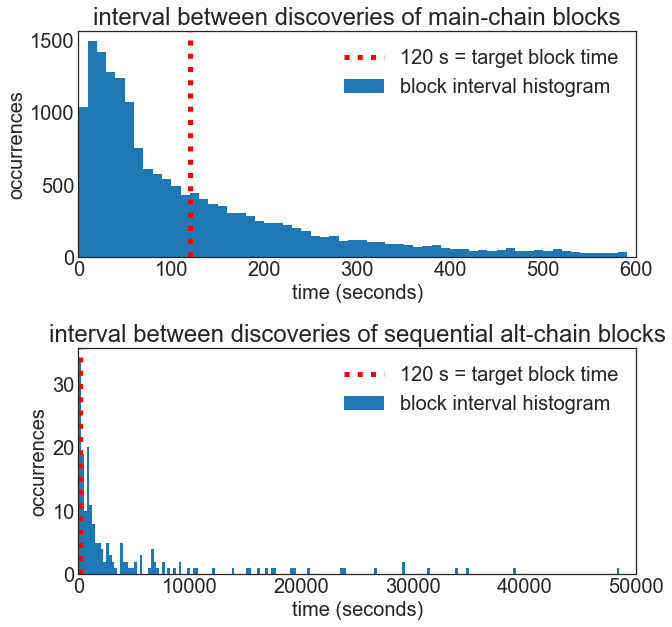

In [17]:
fig = plt.figure(figsize=(10, 10), facecolor="white")
plt.style.use("seaborn-white")
plt.subplots_adjust(
    left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.4
)
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["font.size"] = 20

ax1 = fig.add_subplot(211)
ax1.set_xlabel("time (seconds)")
ax1.set_ylabel("occurrences")
ax1.set_title("interval between discoveries of main-chain blocks")
plt.hist(b0s.delta_time[b0s.delta_time.notnull()], bins=range(0, 600, 10))
ax1.set_xlim((0, 600))
plt.axvline(x=120, c="red", linestyle=":", linewidth=5)
plt.legend(("120 s = target block time", "block interval histogram"))

ax2 = fig.add_subplot(212)
plt.hist(b1s.delta_time[b1s.delta_time.notnull()], bins=range(0, 50000, 250))
ax2.set_xlabel("time (seconds)")
ax2.set_ylabel("occurrences")
ax2.set_title("interval between discoveries of sequential alt-chain blocks")
ax2.set_xlim((0, 50000))
plt.axvline(x=120, c="red", linestyle=":", linewidth=5)
plt.legend(("120 s = target block time", "block interval histogram"))

pass


### Observed wait times

**Main chain:**

The top histogram (main chain) shows roughly the distribution that we would expect: long-tailed with a mean of 2 minutes. There seems to be some skew around 60 seconds, which is peculiar. 

Ittay Eyal and Emin Gün Sirer [point out](http://hackingdistributed.com/2014/01/15/detecting-selfish-mining/) that "One could detect [[selfish mining](https://arxiv.org/pdf/1311.0243.pdf)] by looking at the timestamps on successive blocks in the blockchain. Since mining is essentially an independent random process, we'd expect the interblock time gap to be exponentially distributed. Any deviation from this expectation would be suggestive of selfish mining"

**alt chains:**

The alt-chain histogram shows mining on an entirely different timescale. Blocks are released very belatedly, often hours behind the preceding height.

Note the x-scale in seconds, and the fact that the majority of alt-chain blocks are minutes, hours, or days behind the preceding block. These blocks have NO chance of ever becoming the main chain. Something unusual is happening, and this figure captures multiple phenomena:

-  Most of the natural latency-induced forks would appear in the bin around 120 seconds (2 minutes)

-  Some of the single blocks with extreme times (e.g. ~ 50000 s = 1 month) are probably due to somebody solo mining a block by accident or for fun. 

-  There are many strong chains with blocks on the order of that are too long (e.g. 15 blocks) for the first case, and have too much hashpower for the second case.

### Expected waiting times 

How long do we expect to wait between blocks?? 

"Events that occur independently with some average rate are modeled with a Poisson process. **The waiting times between k occurrences of the event are Erlang distributed.** The related question of the number of events in a given amount of time is described by the Poisson distribution." ... from [Wikipedia](https://en.wikipedia.org/wiki/Erlang_distribution). 

*Credit: Erlang analysis started by Nathan*

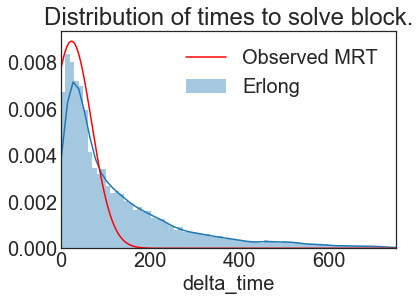

In [18]:
dt = b0s.delta_time[b0s.delta_time > 0]
sns.distplot(dt, bins=np.linspace(0, 1000, 100))
mean = np.nanmean(dt)
stddev = np.std(dt)
lam = mean / stddev ** 2
k = 2000
x = range(10000)
shift = 1975
y = sp.stats.erlang.pdf(x, k, lam)
x_plot = [xi - shift for xi in x]
plt.plot(x_plot, y, color="r", label="Erlong")
plt.xlim(0, 750)
plt.title("Distribution of times to solve block.")
plt.legend(("Observed MRT", "Erlong"))
# plt.savefig("dist")
# plt.figure()
# plt.plot(x, sp.stats.erlang.pdf(x, k, lam, 100000), color='r', label = "Erlong")
pass


If we are correct that Erlang statistics theoretically describe the situation, there are two main reasons why the distribution does not match observations:
-  IsthmusCrypto used arbitrary (and presumably wrong) parameters to make the fit line up
-  This analysis used miner-reported timestamps (MRTs) which are known to be wrong (see Merlin blocks, below). The node-receipt timestamps (NRTs) will accurately reflect the block announcement intervals.

How many alternative blocks did we see that were single orphaned blocks, and how many blocks that were part of longer alternative chains.

In [19]:
orph_block_cut1 = copy(b1s[b1s.alt_chain_length == 1])
orph_block_cut2 = copy(orph_block_cut1[orph_block_cut1.terminal_block == 1])

experiment_time_d = (
    max(orph_block_cut2.block_time) - min(orph_block_cut2.block_time)
) / 86400  # seconds per day
experiment_time_height = max(orph_block_cut2.block_height) - min(
    orph_block_cut2.block_height
)

num_of_orphans = len(orph_block_cut2)
num_alt_chain_blocks = len(b1s) - num_of_orphans

orphans_per_day = num_of_orphans / experiment_time_d
heights_per_orphan = experiment_time_height / num_of_orphans
heights_per_side_block = experiment_time_height / num_alt_chain_blocks

print(
    "Experiment lasted for:"
    + str(round(experiment_time_d))
    + " days = "
    + str(experiment_time_height)
    + " heights"
)
print("Observed " + str(num_of_orphans) + " single orphan blocks")
print(
    "Observed "
    + str(num_alt_chain_blocks)
    + " blocks assocated with longer alternative chains"
)
print(
    "This corresponds to 1 natural orphan per "
    + str(round(heights_per_orphan))
    + " heights"
)
print(
    "This corresponds to 1 alt-chain-related block per "
    + str(round(heights_per_orphan))
    + " heights"
)


Experiment lasted for:85 days = 60171 heights
Observed 22 single orphan blocks
Observed 219 blocks assocated with longer alternative chains
This corresponds to 1 natural orphan per 2735 heights
This corresponds to 1 alt-chain-related block per 2735 heights


Assuming that the longer side chains are a different phenomenon that does not impact the frequency of natural orphaned blocks, how often would we expect to see a triple block?

In [20]:
monero_blocks_per_day = 720
heights_per_triple = heights_per_orphan * heights_per_side_block
triple_frequency_days = heights_per_triple / monero_blocks_per_day
print(
    "Statistically we expect to see a triple block once per "
    + str(round(heights_per_triple))
    + " blocks ("
    + str(round(triple_frequency_days))
    + " days)"
)


Statistically we expect to see a triple block once per 751463 blocks (1044 days)



print('Observed: ' + str(number_of_orphans) + ' over the course of ' + str(round(experiment_time_d)) + ' days.')
print('This corresponds to ' + str(round(orphans_per_day,3)) + ' orphans per day.')
print('Over ' + str(experiment_time_height) + ' blocks, averaged:')
print(str(round(orphans_per_height,5)), ' orphans per height')
print(str(round(1/orphans_per_height)) + ' blocks per orphan')


### Merlin Blocks

Check it out, there appear to be time-traveling blocks in the main chain!

These plots are based off of the miner-reported timestamps (MRTs), which are spoofable. This phenomenon will probably disappear with node-receipt timestamps (NRTs)... 

2.68% of blocks on the main chain were delivered from the future.


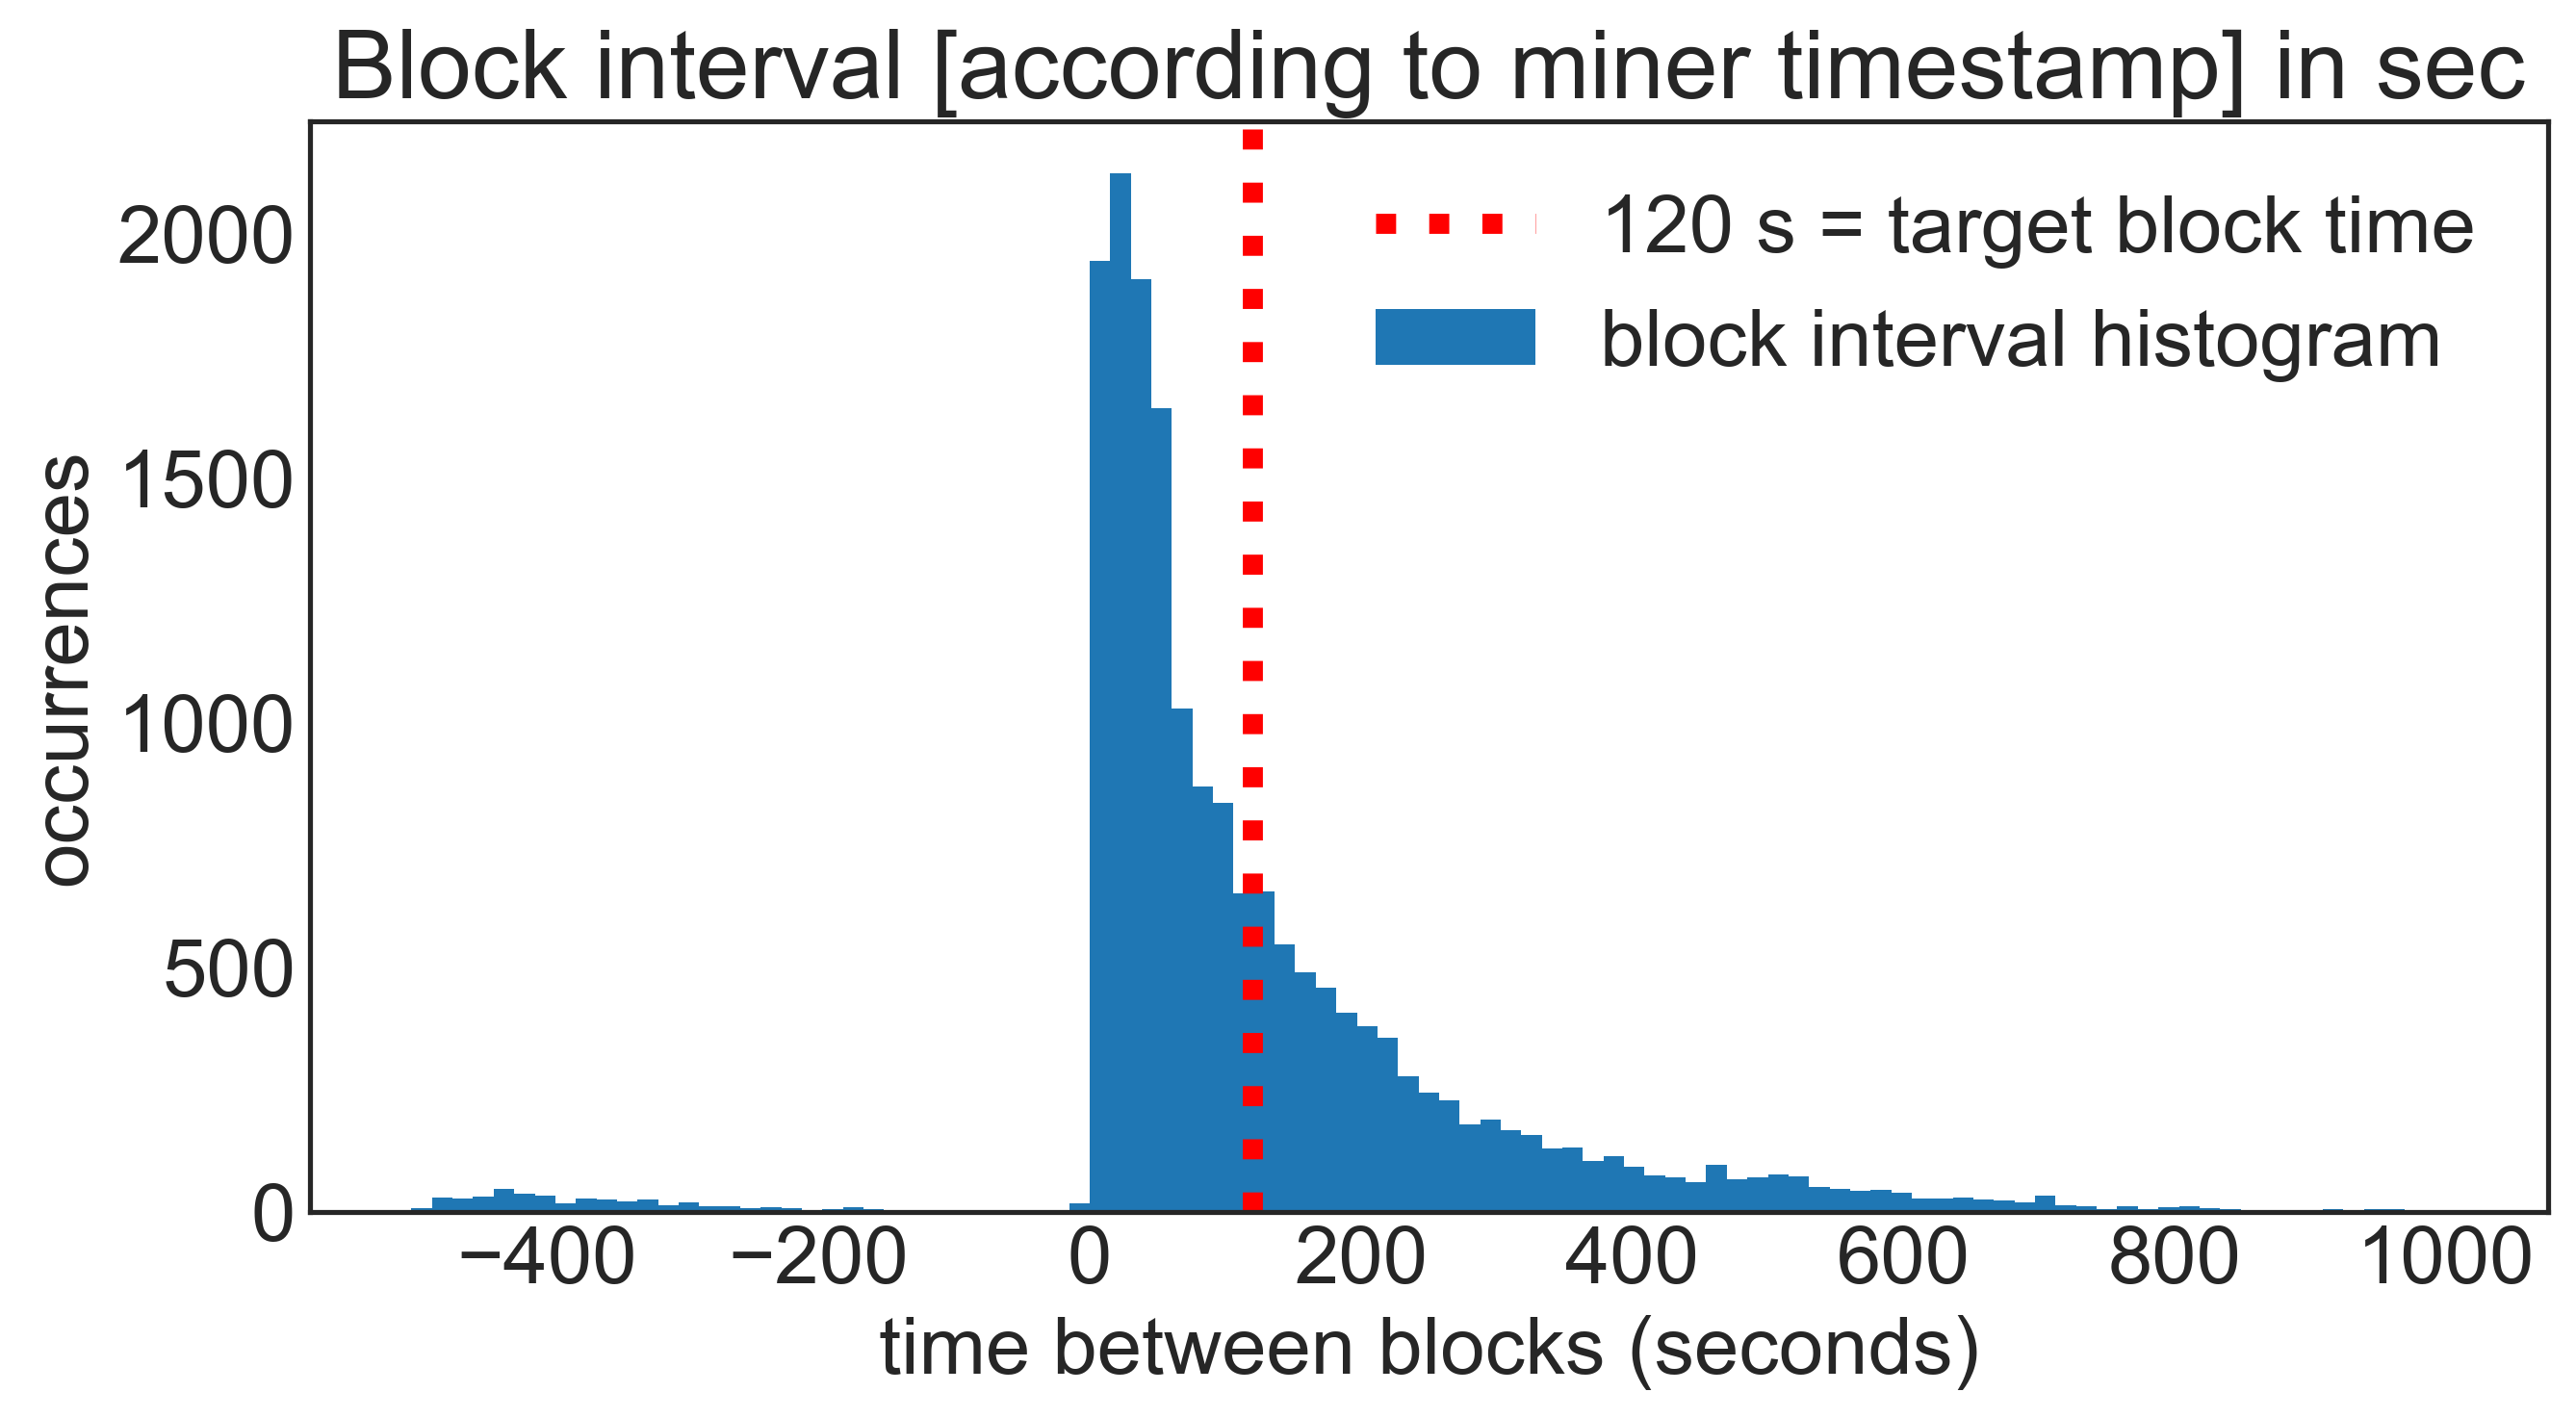

In [21]:
fig = plt.figure(figsize=(10, 5), facecolor="white", dpi=300)
plt.style.use("seaborn-white")
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["font.size"] = 20
plt.hist(b0s.delta_time.dropna(), bins=np.linspace(-500, 1000, 100))

plt.xlabel("time between blocks (seconds)")
plt.ylabel("occurrences")
plt.title("Block interval [according to miner timestamp] in sec")
plt.axvline(x=120, c="red", linestyle=":", linewidth=5)
plt.legend(("120 s = target block time", "block interval histogram"))
pass

print(
    str(round(len(b0s.delta_time[b0s.delta_time < 0]) / len(b0s.delta_time) * 100, 2))
    + "% of blocks on the main chain were delivered from the future."
)


**Time-traveling blocks:**

About 2.5% of blocks on the main chain arrive with a miner timestamp BEFORE the timestamp of the block prior. This conclusively shows that miner-reported timestamps cannot be trusted, and further analysis must rely on node-reported timestamps.

### Direction of time travel

Let `M` be the height of a Merlin block, meaning that `[time(M) < time(M-1)]`. This could be caused by :
-  block `M-1` being mined with a false late timestamp
-  block `M` being mined with a false early timestamp

Let's take a look at which it could be, by looking at the discovery times of the blocks before and after the Merlin blocks.

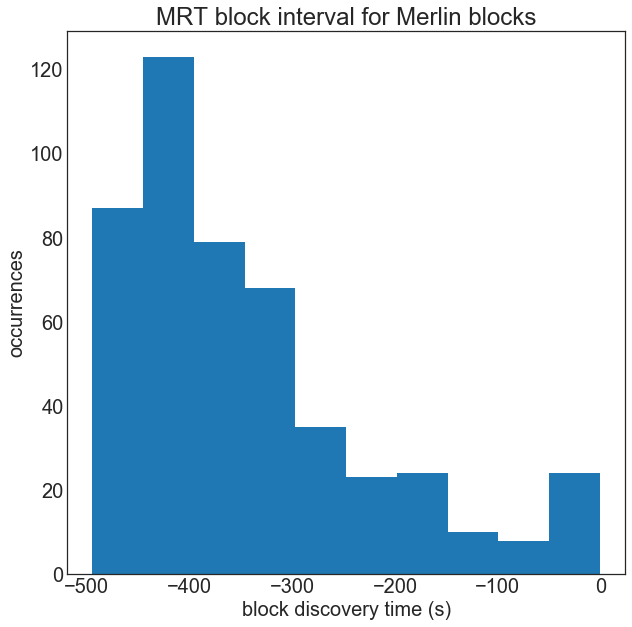

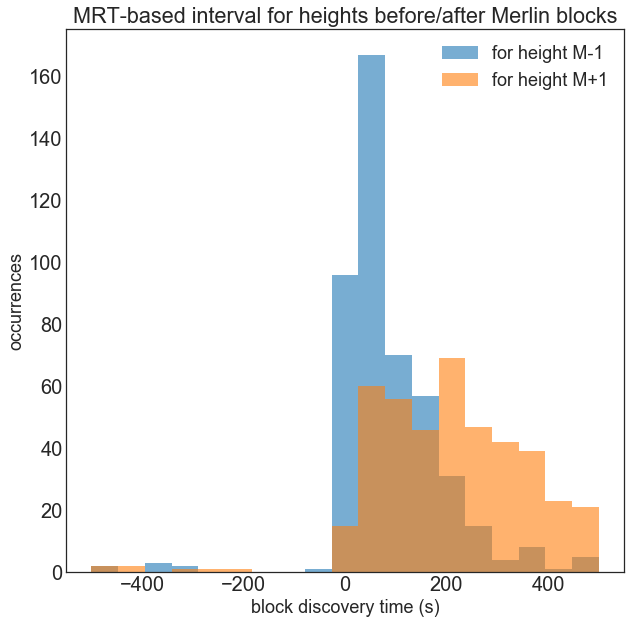

In [22]:
# Indexing
M_block_inds = b0s.index[b0s.merlin_block == 1].tolist()
M_parent_inds = [x - 1 for x in M_block_inds]
M_child_inds = [x + 1 for x in M_block_inds]

fig = plt.figure(figsize=(10, 10))
plt.style.use("seaborn-white")
plt.subplots_adjust(
    left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.4
)
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["font.size"] = 20
plt.title("MRT block interval for Merlin blocks")
plt.xlabel("block discovery time (s)")
plt.ylabel("occurrences")
plt.hist(b0s.delta_time[M_block_inds].dropna())

fig = plt.figure(figsize=(10, 10))
plt.style.use("seaborn-white")
plt.subplots_adjust(
    left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.4
)
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["font.size"] = 18
plt.title("MRT-based interval for heights before/after Merlin blocks")
plt.xlabel("block discovery time (s)")
plt.ylabel("occurrences")
# plt.hist(b0s.delta_time.dropna(), alpha=0.5, bins=np.linspace(-500,500,500))
binnum = 20
plt.hist(
    b0s.delta_time[M_parent_inds].dropna(),
    alpha=0.6,
    bins=np.linspace(-500, 500, binnum),
)  # gets a different warning
plt.hist(
    b0s.delta_time[M_child_inds].dropna(),
    alpha=0.6,
    bins=np.linspace(-500, 500, binnum),
)  # gets a different warning
plt.legend(("for height M-1", "for height M+1"))
pass


From the bottom plot, we notice that the blocks *preceding* (according to height) Merlin blocks to have mostly arrived on schedule (since, qualitatively at least, the interval distribution for M-1 blocks matches the interval distribution for all blocks)

However, many of the blocks *following* (according to height) Merlin blocks arrive conspicuously late...! 

**This suggests that many of the Merlin blocks appear to be time traveling because their miner-reported timestamp is too early** (not because the block at height M-1 was stamped too late)

### Fishing for multi-Merlans

Interestingly, the above plot shows Merlin blocks that follow Merlin blocks (and are followed by Merlin blocks)! Let's fish some of these up for visual inspection, since this would mean multiple timestamps moving in reverse...

In [23]:
b0s_M = copy(b0s[b0s.merlin_block == 1])

del b0s_M["delta_time"]
# b0s_M['delta_time'] = b0s_M['block_time']-b0s_M['block_time'].shift()
b0s_M["delta_height"] = b0s_M["block_height"] - b0s_M["block_height"].shift()

################################################
## Sticking a pin in this section for now.....
## Not sure why 1589928 is flagged as a Merlin?


## Investigate alt chains

Let's look at alt chains. The following plots will show how quickly each chain grew.

### How long do these alt chains persist?

We expect lots of alt chains with length 1 or 2 from natural causes. 

Is anybody out there dumping mining power into longer altchains? We'll conaltr 'longer' in terms of height (top plot), and in terms of time (bottom plot)

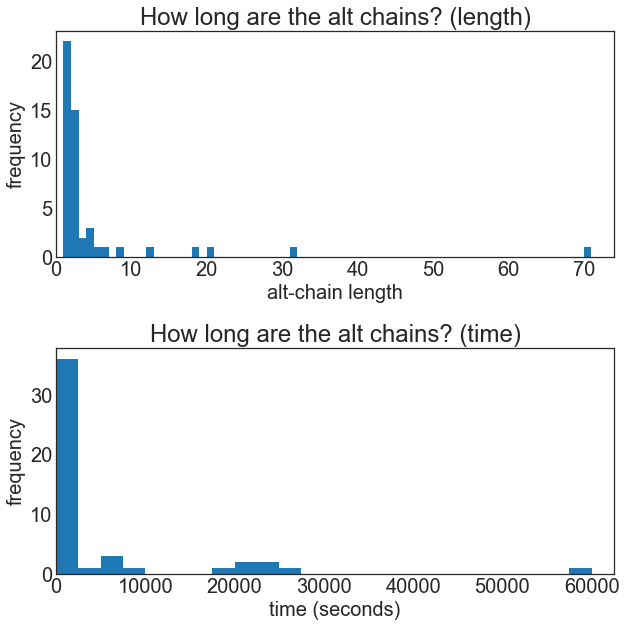

In [24]:
fig = plt.figure(figsize=(10, 10))
plt.style.use("seaborn-white")
plt.subplots_adjust(
    left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.4
)
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["font.size"] = 20

ax1 = fig.add_subplot(211)
ax1.set_xlabel("alt-chain length")
ax1.set_ylabel("frequency")
ax1.set_title("How long are the alt chains? (length)")
plt.hist(b1s.alt_chain_length[b1s.terminal_block == 1], bins=range(0, 75))
ax1.autoscale(enable=True, axis="x", tight=True)

ax2 = fig.add_subplot(212)
plt.hist(b1s.alt_chain_time[b1s.terminal_block == 1], bins=range(0, 65000, 2500))
ax2.set_xlabel("time (seconds)")
ax2.set_ylabel("frequency")
ax2.set_title("How long are the alt chains? (time)")
ax2.autoscale(enable=True, axis="x", tight=True)
pass


Unexpectedly, there are lots of alt chains being mined 10, 20, and 30 blocks deep (top plot).

Some of these futile alt chains are mined for weeks (bottom plot)

Highly unnatural...

## A closer look at the growth of alt chains

It is time to individually inspect different alt chains, and see how fast they were produced. The plots below fingerprint the growth of each alt chain.

Each chain is colored/numbered differently. Each point shows a single block: the x-axis position indicates how long alt chain has grown, and the y-axis position indicates the *cumulative* time that has gone into mining that particular alt chain (calculated as the difference between the timestamp on this block and its first block).

The speed with which a given entity can produce blocks for their altchain is proportional to their hash power. This can be used to identify distinct signatures of different phenomena or entities! Two different long alt chains that were mined on the same equipment will show up together on these plots, assuming that their hashrate hasn't changed between runs.

The red line shows 2-minutes per block, so any entity producing blocks near that speed can feasibly overtake (and become) the main chain. The further a alt chain is from the red line, the more astronomically improbable this becomes.

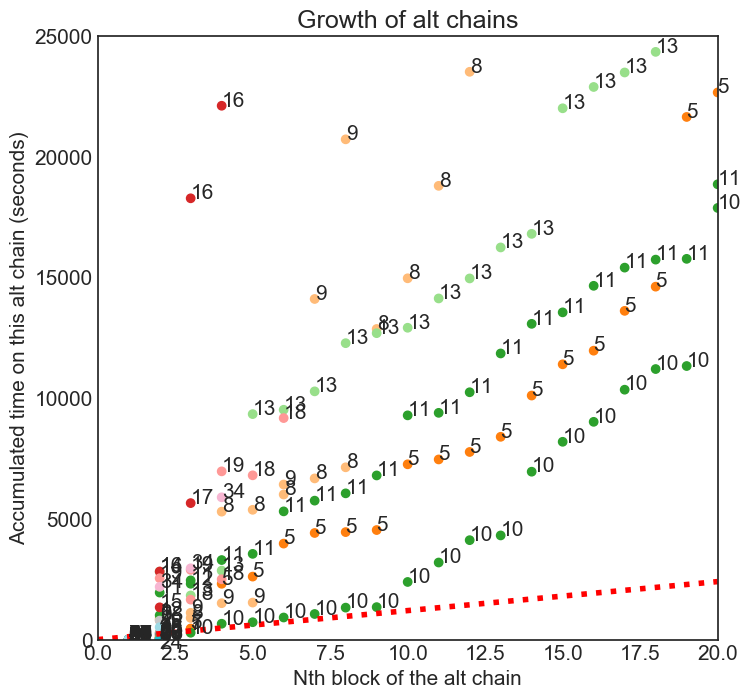

In [25]:
# Let's take a look at the first 20 blocks:
max_chain_length = 20
max_chain_time = 25000
norm_block_time = 120  # seconds

fig = plt.figure(figsize=(8, 8), dpi=100)
plt.style.use("seaborn-white")
plt.rcParams["ytick.labelsize"] = 15
plt.rcParams["xtick.labelsize"] = 15
plt.rcParams["font.size"] = 15

plt.scatter(
    b1s.alt_chain_length, b1s.alt_chain_time + 1, c=b1s.alt_chain_ID, cmap="tab20"
)
# fig.suptitle('Looking at alt chain lengths and time, all blocks')
plt.xlabel("Nth block of the alt chain")
plt.ylabel("Accumulated time on this alt chain (seconds)")
plt.xlim((0, max_chain_length))
plt.ylim((0, max_chain_time))
plt.title("Growth of alt chains")

for i, txt in enumerate(b1s.alt_chain_ID):
    # print(i)
    X = b1s.alt_chain_length[i]
    Y = b1s.alt_chain_time[i]
    S = b1s.alt_chain_ID[i]
    # print("X = " + str(X), " // Y = " + str(Y) + " // S = " + str(S))
    if i > 0 and X <= max_chain_length and Y <= max_chain_time:
        plt.text(X, Y, S)

# Add on a regular rate
plt.plot(
    (0, max_chain_length),
    (0, max_chain_length * norm_block_time),
    c="red",
    linewidth=4,
    linestyle=":",
)
pass


**Wow** there are several interesting things to note:

Several of the alt chains, separated by weeks, show the exact same signature in hashrate (e.g. #5 and #11) and presumably were produced by the same equipment

alt chain #10 produced the first 8 blocks at approximately 2 minutes per block! This could indicate two things:
-  A alt chain came within a razor's edge of overtaking the main chain
-  A alt chain DID overtake the main chain (!!!) so the original version is marked as "alternate" here

Something seems to cause the chains to lose steam about 7 or 8 blocks in. This could be a coincidence from looking at a small number of examples, but seems prominent in #5, #10, #11, #13. Equipment overheating??

Who could have that much hash power? And these are all since July after we were supposedly rid of ASICs.

Absurdly, one of the alt chains was 70 blocks long, with an average of a four hour block discovery time. 
-  To reliably mine at ~ 4 hr/block the entity must have around 1% of total network hashrate!
-  This single alt chain would have used around 40,000 EUR worth of energy! 

That is not something that an unlucky amateur miner would accidentally overlook. Here's a zoomed-out version of the above plot:

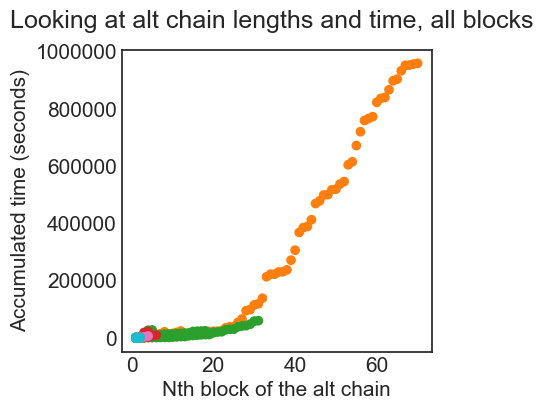

In [26]:
fig = plt.figure(figsize=(4, 4), dpi=100)
plt.scatter(
    b1s.alt_chain_length, b1s.alt_chain_time + 1, c=b1s.alt_chain_ID, cmap="tab10"
)
fig.suptitle("Looking at alt chain lengths and time, all blocks")
plt.xlabel("Nth block of the alt chain")
plt.ylabel("Accumulated time (seconds)")
plt.axis("tight")
pass


Let's look at these chains in terms of a (very rough and noisy) estimate of their hashpower, which is inversely proportional the length of time between discovering blocks.

This can be normalized by the network discovery time (average 120s) to the alt chain's hashrate relative to the network-wide hashrate. 

`fraction_of_network_hashrate = [(alt chain discovery time)/(normal time = 120 s)]^(-1)`

This is a **really** noisy proxy, given the element of chance in block discovery. However, it can be seen that some chains like #10 and #13 consistently perform as though they have a *significant* amount of hash power. Don't stare at this plot for too long, it needs smoothing and is better described by summary statistics that follow later.

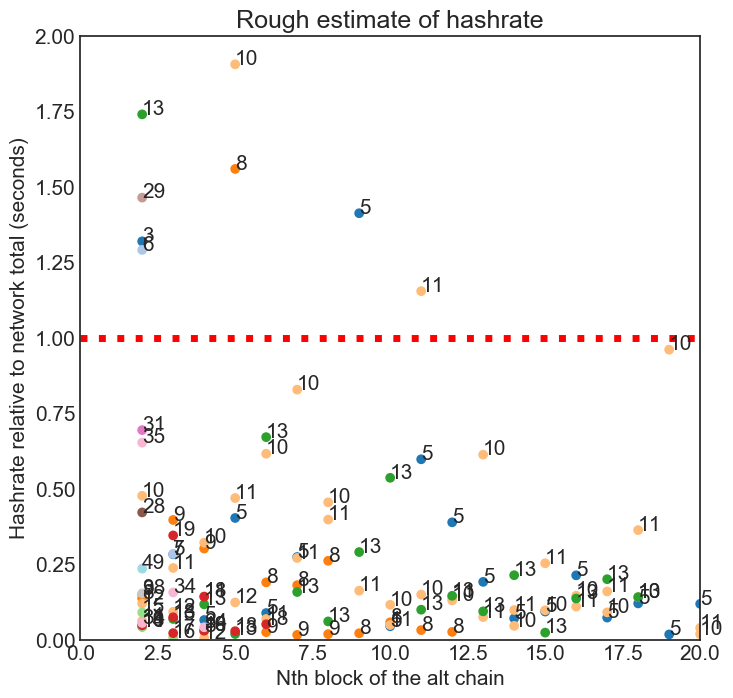

In [27]:
# Let's take a look at the first 20 blocks:
max_chain_length = 20
norm_block_time = 120  # seconds
max_prop = 2

fig = plt.figure(figsize=(8, 8), dpi=100)
plt.style.use("seaborn-white")
plt.rcParams["ytick.labelsize"] = 15
plt.rcParams["xtick.labelsize"] = 15
plt.rcParams["font.size"] = 15

plt.scatter(
    b1s.alt_chain_length,
    np.reciprocal(b1s.delta_time / norm_block_time),
    c=b1s.alt_chain_ID,
    cmap="tab20",
)

# fig.suptitle('Looking at alt chain lengths and time, all blocks')
plt.xlabel("Nth block of the alt chain")
plt.ylabel("Hashrate relative to network total (seconds)")
plt.xlim((0, max_chain_length))
plt.ylim((0, max_prop))
plt.title("Rough estimate of hashrate")

for i, txt in enumerate(b1s.alt_chain_ID):
    # print(i)
    X = b1s.alt_chain_length[i]
    Y = np.reciprocal(b1s.delta_time[i] / 120)
    S = b1s.alt_chain_ID[i]
    # print("X = " + str(X), " // Y = " + str(Y) + " // S = " + str(S))
    if i > 0 and X <= max_chain_length and Y <= max_prop and Y > 0:
        plt.text(X, Y, S)
        pass

# Add on a regular rate
plt.axhline(y=1, c="red", linestyle=":", linewidth=5)
pass


### Ratio of chain length to chain time

For each chain, we calculate the total chain_length/chain_time to produce the average blocks per second

This should be directly proportional to the hashrate being used to mine that chain

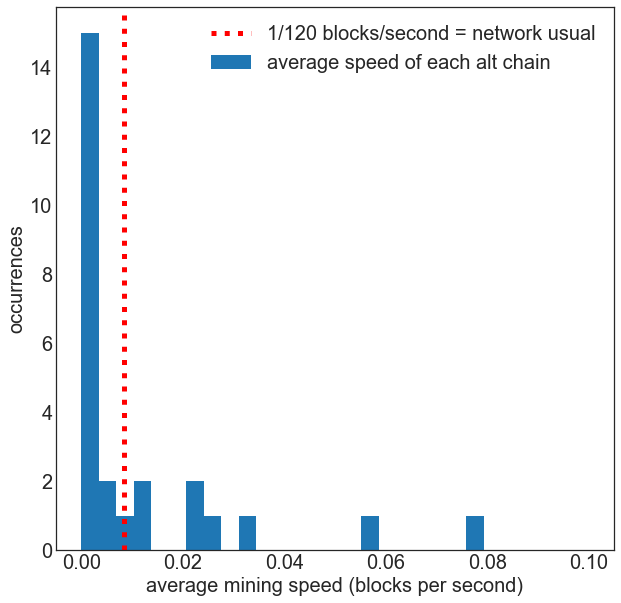

In [28]:
b1s_terminal = copy(b1s[b1s.terminal_block == 1])
b1s_terminal["average_speed"] = np.nan
b1s_terminal["fraction_of_network_hashrate"] = np.nan


# Loop over rows = blocks
for index, row in b1s_terminal.iterrows():
    if b1s_terminal.alt_chain_time[index] > 0:
        b1s_terminal.loc[index, ("average_speed")] = (
            b1s_terminal.alt_chain_length[index] / b1s_terminal.alt_chain_time[index]
        )
        b1s_terminal.loc[index, ("fraction_of_network_hashrate")] = (
            b1s_terminal.average_speed[index] * 120
        )  # normalized against the usual 1/120 blocks/second


fig = plt.figure(figsize=(10, 10), facecolor="white")
plt.style.use("seaborn-white")
plt.subplots_adjust(
    left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.4
)
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["font.size"] = 20

plt.hist(b1s_terminal.average_speed.dropna(), bins=np.linspace(0, 0.1, 30))
plt.xlabel("average mining speed (blocks per second)")
plt.ylabel("occurrences")
plt.title("")
plt.axvline(x=(1 / 120), c="red", linestyle=":", linewidth=5)

plt.legend(("1/120 blocks/second = network usual", "average speed of each alt chain"))

pass


Almost all of the alternate chains have an average speed that is SLOWER than the main chain (to the left of red line).

Some of the chains clocked in with speeds higher than the network average. Let's see if these are long chains that should have overtaken, or fluke statistics from short chains.

In [29]:
b1s_order = copy(b1s_terminal.sort_values(["average_speed"], ascending=False))
display(
    b1s_order.dropna()[
        [
            "alt_chain_ID",
            "alt_chain_length",
            "alt_chain_time",
            "average_speed",
            "fraction_of_network_hashrate",
        ]
    ]
)


,alt_chain_ID,alt_chain_length,alt_chain_time,average_speed,fraction_of_network_hashrate
236,47,2.0,17,0.117647,14.117647
222,36,2.0,26,0.076923,9.230769
200,23,2.0,36,0.055556,6.666667
228,40,2.0,59,0.033898,4.067797
209,29,2.0,82,0.024390,2.926829
4,3,2.0,91,0.021978,2.637363
77,6,2.0,93,0.021505,2.580645
212,31,2.0,173,0.011561,1.387283
220,35,2.0,184,0.010870,1.304348
207,28,2.0,285,0.007018,0.842105


As expected, the chains that clocked in faster than average were all just 2-block detours.

Let's take a look without those

In [30]:
b1s_order = copy(b1s_order[b1s_order.alt_chain_length > 2])
display(
    b1s_order[
        [
            "alt_chain_ID",
            "alt_chain_length",
            "alt_chain_time",
            "average_speed",
            "fraction_of_network_hashrate",
        ]
    ]
)


,alt_chain_ID,alt_chain_length,alt_chain_time,average_speed,fraction_of_network_hashrate
80,7,3.0,437,0.006865,0.823799
120,10,20.0,17865,0.001120,0.134341
174,13,18.0,24325,0.000740,0.088798
218,34,4.0,5888,0.000679,0.081522
191,18,6.0,9168,0.000654,0.078534
195,19,4.0,6962,0.000575,0.068946
185,17,3.0,5648,0.000531,0.063739
151,11,31.0,59577,0.000520,0.062440
92,8,12.0,23500,0.000511,0.061277
100,9,8.0,20705,0.000386,0.046366


### Surprising observations:

Note that chain with ID 10 was 20 blocks long, and averaged production at a speed that would have required **13% of the total network hashrate.**

Chain ID 13 managed 18 blocks at a speed consistent with having **8% of the total network hashrate.**

## Comparison between chains

Now we look whether an influx of hashrate onto an alt chain corresponds with loss of hashrate on the main chain.

We'll stick with looking at times, because taking the reciprocal makes a noisy function noisier

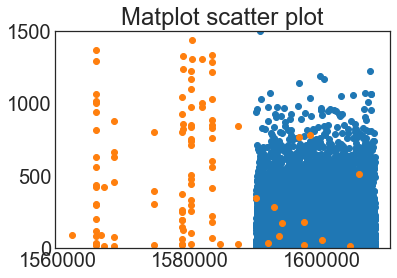

In [31]:
# Create plot
fig = plt.figure()

plt.scatter(b0s.block_height, b0s.delta_time)
plt.scatter(b1s.block_height, b1s.delta_time)

# plt.xlim(1580000, 1615000)
plt.ylim(0, 1500)
plt.title("Matplot scatter plot")
plt.show()


..... This doesn't line up exactly right. Need to get b0 times during b1 stretches...

## Summarization of the alt chains

Quickly spitting out some text data so I can cross-reference these alt chains against mining timing on the main chain.

In [32]:
verbose_text_output = 1

if verbose_text_output:
    for i, x in enumerate(b1s.alt_chain_ID.unique()):
        try:
            # print('alt chain #' + str(i) + ' median time: ', + np.median(b1s.block_time[b1s.alt_chain_ID==i]))
            print(
                "alt chain #"
                + str(i)
                + " median time: "
                + time.strftime(
                    "%Y-%m-%d %H:%M:%S",
                    time.localtime(np.median(b1s.block_time[b1s.alt_chain_ID == i])),
                )
            )
            print(
                "\t... started at height "
                + str(min(b1s.block_height[b1s.alt_chain_ID == i]))
                + "\n"
            )
        except:
            pass


alt chain #0 median time: 2018-04-04 23:11:27
	... started at height 1545098

alt chain #1 median time: 2018-04-06 03:24:11
	... started at height 1546000

alt chain #2 median time: 2018-04-10 00:11:39
	... started at height 1547963

alt chain #3 median time: 2018-04-29 15:03:35
	... started at height 1562061

alt chain #4 median time: 2018-05-01 19:00:07
	... started at height 1563626

alt chain #5 median time: 2018-05-07 07:36:20
	... started at height 1565690

alt chain #6 median time: 2018-05-05 20:01:05
	... started at height 1566500

alt chain #7 median time: 2018-05-06 10:06:00
	... started at height 1566908

alt chain #8 median time: 2018-05-08 18:22:59
	... started at height 1568536

alt chain #9 median time: 2018-05-17 01:15:02
	... started at height 1574526

alt chain #10 median time: 2018-05-23 02:55:11
	... started at height 1578847

alt chain #11 median time: 2018-05-25 03:13:18
	... started at height 1580196

alt chain #12 median time: 2018-05-27 07:47:34
	... started at

# Work in progress. Check back later for more excitement!

Ah, here's a bug to fix:

NaNs in delta_time get marked as a `merlin_block` which is not true

In [33]:
b0s[b0s.merlin_block==1]

,block_time,block_height,block_nonce,delta_time,merlin_block,delta_height
155,1528424793,1590205,3221227151,-414.0,1,1.0
202,1528429666,1590248,2147494938,-397.0,1,1.0
352,1528448401,1590402,357919038,-398.0,1,1.0
386,1528451535,1590434,4040804,-421.0,1,1.0
450,1528459630,1590496,1307164693,-378.0,1,1.0
501,1528465021,1590547,1050939,-407.0,1,1.0
552,1528471884,1590598,1777,-27.0,1,1.0
558,1528472653,1590606,791210,-386.0,1,1.0
584,1528475048,1590632,205451,-432.0,1,1.0
658,1528485921,1590709,1086925,-402.0,1,1.0
